## Model Evaluation and Visualization

### Import Libraries

In [11]:
import os
import json

import torch 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.transforms as T

from model import AutoTransformerModel
from data import BinaryMedicalDataset
from constants import *

from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, precision_score, f1_score, recall_score, accuracy_score
from sklearn.metrics import RocCurveDisplay 

### Configuration Setup

In [12]:
class Config:
    name = "new_train09"
    model = "swin"
    batch_size = 32
    device = 7
args = Config()

### Model Loading and Inference

In [13]:
model = AutoTransformerModel(model_path=MODEL_PATH[args.model])
checkpoint = torch.load(f"weight/{args.name}.pt", weights_only=True)
model.load_state_dict(checkpoint)
model.to(args.device)

test_data = BinaryMedicalDataset(dir=TEST_DIR, model_path=MODEL_PATH[args.model])
test_loader= DataLoader(test_data, args.batch_size)
predictions, true_labels, confidence_scores = [], [], []

model.eval()
with torch.no_grad():
    for X, y in tqdm(test_loader, desc="Running Test"):
        X = X.to(args.device)
        pred = model(X).cpu().numpy()
        predicted_labels = (pred >= 0.5).astype(int)
        predictions.extend(predicted_labels)
        true_labels.extend(y)
        confidence_scores.extend(pred)

Running Test: 100%|██████████| 8/8 [00:59<00:00,  7.44s/it]


### Evaluation Metrics

In [14]:
from sklearn.metrics import classification_report

predictions = np.array(predictions, dtype=float)
true_labels = np.array(true_labels, dtype=int)

print(classification_report(true_labels, predictions, 
                          target_names=['Vasculitis/Psoriasis', 'PPD/Statis'],
                          digits=4))

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')
f1 = f1_score(true_labels, predictions, average='macro')

print(f"{'Accuracy:':<12} {accuracy:.5f}")
print(f"{'Precision:':<12} {precision:.5f}")
print(f"{'Recall:':<12} {recall:.5f}")
print(f"{'F1 Score:':<12} {f1:.5f}")

                      precision    recall  f1-score   support

Vasculitis/Psoriasis     0.9076    0.9391    0.9231       115
          PPD/Statis     0.9474    0.9197    0.9333       137

            accuracy                         0.9286       252
           macro avg     0.9275    0.9294    0.9282       252
        weighted avg     0.9292    0.9286    0.9287       252

Accuracy:    0.92857
Precision:   0.92747
Recall:      0.92942
F1 Score:    0.92821


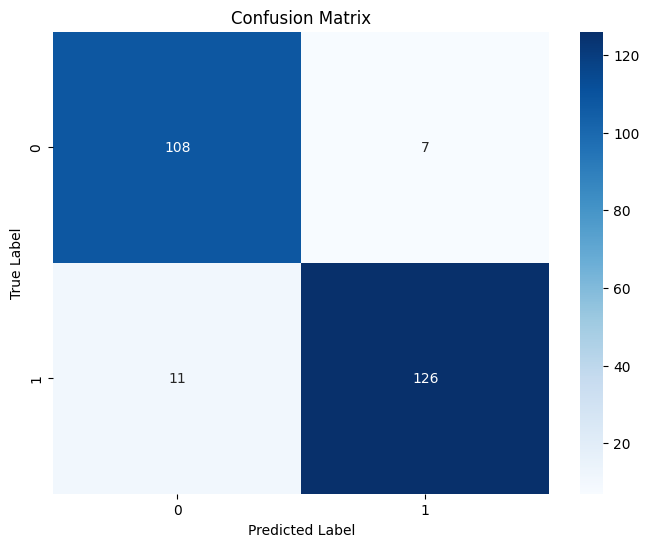

In [15]:
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

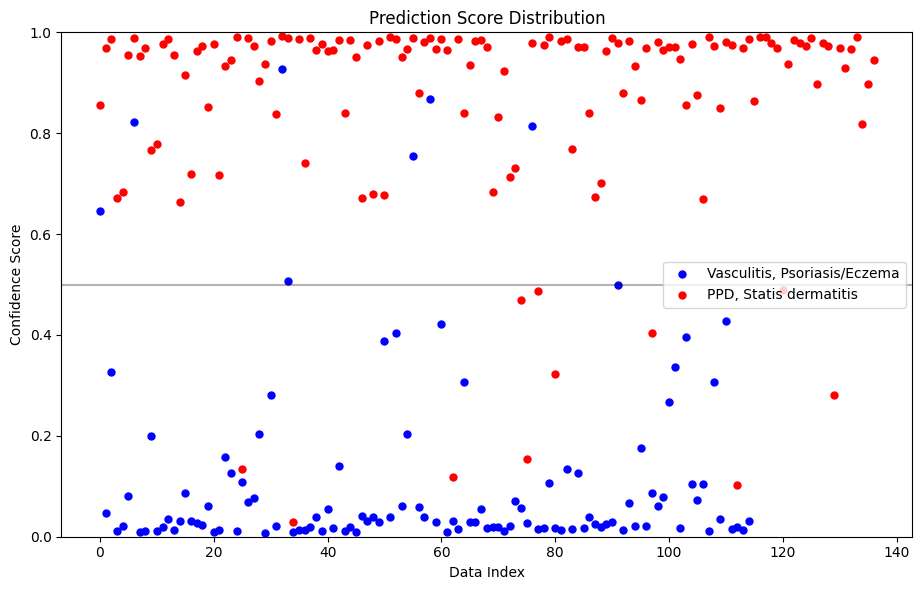

In [16]:
x = np.arange(len(confidence_scores))
y = np.array(confidence_scores)

t = np.where(true_labels[:-1] != true_labels[1:])[0][0] + 1


plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.title("Prediction Score Distribution")
plt.scatter(x[:t], y[:t], color='b',s=100, marker='.', label='Vasculitis, Psoriasis/Eczema')
plt.scatter(x[t:] - t, y[t:], color='r',s=100, marker='.', label='PPD, Statis dermatitis')
plt.axhline(y=0.5, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Data Index')
plt.ylabel('Confidence Score')
plt.ylim([0, 1])
plt.legend()

plt.tight_layout()
plt.show()

#0.50042105

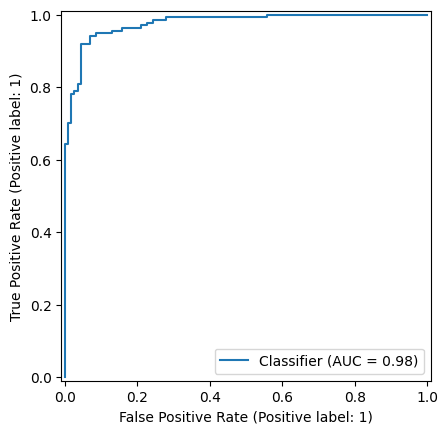

In [17]:
RocCurveDisplay.from_predictions(true_labels, confidence_scores)
plt.show()

### Error Analysis

In [18]:
# swin_unnormalize
unnormalize = T.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

# vit_unnormalize
# unnormalize = T.Normalize(
#     mean=[-1,-1,-1],
#     std=[1/0.5, 1/0.5, 1/0.5]
# )



# count = []
# for i in range(len(true_labels)):
#     if predictions[i] != true_labels[i]:
#         count.append(i)

# for j in count[:1]:
#     restored_img = unnormalize(test_data[j][0])
#     restored_img = torch.clamp(restored_img, 0, 1)
#     test_img = restored_img.permute(1, 2, 0)
#     # plt.imshow(test_img)
#     # plt.title(f"True Label: {true_labels[j]} | Predicted: {predictions[j]} | Confidence: {100*confidence_scores[j]: .2f}%" )
#     # plt.show()
    
    
#     plt.imshow(test_img)
#     if true_labels[j]==0:
#         plt.title(f"True Label: Vasculitis, Psoriasis/Eczema\nPredicted: PPD, Stasis dermatitis, lipodermatosclerosis\nConfidence: {100 * (1-confidence_scores[j]):.2f}%", fontsize=10)
#     else: #true_label==1
#         plt.title(f"True Label: PPD, Stasis dermatitis, lipodermatosclerosis\nPredicted: Vasculitis, Psoriasis/Eczema\nConfidence: {100 * confidence_scores[j]:.2f}%", fontsize=10)
#     plt.show()
    

In [19]:
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

model.swinv2.embeddings.patch_embeddings.projection.weight: requires_grad=False
model.swinv2.embeddings.patch_embeddings.projection.bias: requires_grad=False
model.swinv2.embeddings.norm.weight: requires_grad=False
model.swinv2.embeddings.norm.bias: requires_grad=False
model.swinv2.encoder.layers.0.blocks.0.attention.self.logit_scale: requires_grad=False
model.swinv2.encoder.layers.0.blocks.0.attention.self.continuous_position_bias_mlp.0.weight: requires_grad=False
model.swinv2.encoder.layers.0.blocks.0.attention.self.continuous_position_bias_mlp.0.bias: requires_grad=False
model.swinv2.encoder.layers.0.blocks.0.attention.self.continuous_position_bias_mlp.2.weight: requires_grad=False
model.swinv2.encoder.layers.0.blocks.0.attention.self.query.weight: requires_grad=False
model.swinv2.encoder.layers.0.blocks.0.attention.self.query.bias: requires_grad=False
model.swinv2.encoder.layers.0.blocks.0.attention.self.key.weight: requires_grad=False
model.swinv2.encoder.layers.0.blocks.0.attenti

### Visualization

input_size: torch.Size([3, 384, 384])


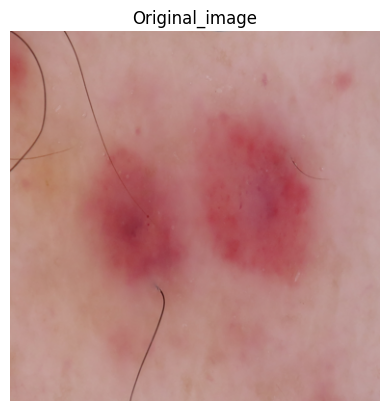

rgb_img: (384, 384, 3)
(384, 384)


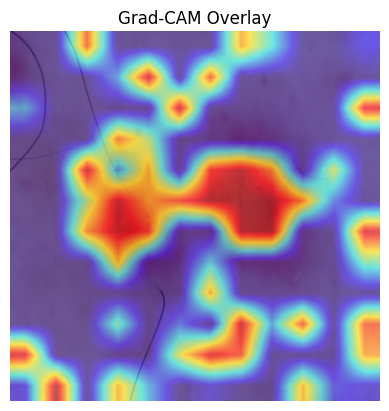

In [21]:
import cv2
from transformers import AutoImageProcessor
from PIL import Image
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget, BinaryClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt


img_path="/DATA/jincheol/dataset/skin_dataset_split/test/class0_others/class0_others_87.jpg"
processor = AutoImageProcessor.from_pretrained(MODEL_PATH[args.model], use_fast=True)
input_image = Image.open(img_path).convert('RGB')  # Ensure image is in RGB format
input_tensor = processor(Image.open(img_path) , return_tensors="pt")["pixel_values"]
input_tensor = input_tensor.to(args.device) 

print(f"input_size: {input_tensor.squeeze(0).size()}")

#swin_transformer
unnormalize = T.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)


#vision_transformer
# unnormalize = T.Normalize(
#     mean=[-1,-1,-1],
#     std=[1 / 0.5, 1 / 0.5, 1 / 0.5]
# )


input_tensor = unnormalize(input_tensor)
input_tensor = torch.clamp(input_tensor, 0, 1)  # [0, 1] 범위로 조정

rgb_img = input_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()

plt.imshow(rgb_img)
plt.axis("off")
plt.title("Original_image")
plt.show()

print(f"rgb_img: {rgb_img.shape}")




# vit_reshape
# def reshape_transform(tensor, height=14, width=14):
#     result = tensor[:, 1:, :].reshape(tensor.size(0),
#                                       height, width, tensor.size(2))

#     # Bring the channels to the first dimension,
#     # like in CNNs.
#     result = result.transpose(2, 3).transpose(1, 2)
#     return result



#swin_transformer_reshape  
def reshape_transform(tensor, height=12, width=12):
    result = tensor.reshape(tensor.size(0),
        height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result



# We have to specify the target we want to generate the CAM for.
layer = model.model.swinv2.encoder.layers[-1].blocks[-1].layernorm_after

#print(layer)

# layer=model.model.vit.encoder.layer[11].attention.attention

targets = [ClassifierOutputTarget(1)]

#targets = BinaryClassifierOutputTarget(1)
model.eval()

# Construct the CAM object once, and then re-use it on many images.
with EigenCAM(model=model, target_layers=[layer], reshape_transform=reshape_transform) as cam:
  # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
  grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

  #print(grayscale_cam.shape)
  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]
  
  print(grayscale_cam.shape)  # 출력 형태 확인
  visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

  
plt.imshow(visualization)
plt.axis("off")
plt.title("Grad-CAM Overlay")
plt.show()